# Reading external station data into Pyaerocom

In [1]:
import pyaerocom as pya
from pyaerocom.io.utils import browse_database
from pyaerocom.griddeddata import GriddedData
from pyaerocom.ungriddeddata import UngriddedData
import pandas as pd
from pyaerocom.stationdata import StationData
from pyaerocom.colocation import colocate_gridded_ungridded
from pyaerocom.io.readgridded import ReadGridded
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyaerocom.plot.plotscatter import plot_scatter_aerocom
import numpy as np

To demonstrate how to add station data that outside of the AeroCom database we will use monthly data of coarse mode AOD from 23 AERONET stations in East Asia (this data are also available in AeroCom database).


In [15]:
!head -n 28 demo_datasets/AERONET_V2_SDA_od550gt1aer2010_EastAsia.csv

Aeronet SDA coarse mode AOD Monthly data from East Asian stations


,Longitude,Latitude
Baengnyeong,124.630278,37.966111
Beijing_RADI,116.3786,40.0048
Chen-Kung_Univ,120.204664,22.993419
Dalanzadgad,104.419167,43.577222
EPA-NCU,121.185483,24.967533
Gwangju_GIST,126.843139,35.228278
Hong_Kong_Hok_Tsui,114.258,22.2097
Hong_Kong_PolyU,114.179722,22.303333
Lanzhou_City,103.8534,36.04805
Lulin,120.873611,23.468611
Minqin,102.959,38.607
NAM_CO,90.96245,30.772517
NCU_Taiwan,121.187508,24.967662
NUIST,118.71715,32.206483
Noto,137.136944,37.334444
Osaka,135.590633,34.650933
QOMS_CAS,86.948056,28.365
SACOL,104.137083,35.946
Taihu,120.215333,31.421
Taipei_CWB,121.53837,25.014683
XiangHe,116.9615,39.7536
Xinglong,117.578333,40.396389
Yeomsan-Myeon,126.303012,35.23666



Read in the station coordinates and the station AOD.

In [3]:
station_coordinates = pd.read_csv('demo_datasets/AERONET_V2_SDA_od550gt1aer2010_EastAsia.csv',index_col=0, skiprows=4,nrows=23, names=['Station_name','Longitude','Latitude'])

In [4]:
! tail -n 14 AERONET_V2_SDA_od550gt1aer2010_EastAsia.csv

tail: cannot open 'AERONET_V2_SDA_od550gt1aer2010_EastAsia.csv' for reading: No such file or directory


In [5]:
data = pd.read_csv('demo_datasets/AERONET_V2_SDA_od550gt1aer2010_EastAsia.csv', skiprows=29,names=station_coordinates.index)

In [6]:
data

,Baengnyeong,Beijing_RADI,Chen-Kung_Univ,Dalanzadgad,EPA-NCU,Gwangju_GIST,Hong_Kong_Hok_Tsui,Hong_Kong_PolyU,Lanzhou_City,Lulin,...,NUIST,Noto,Osaka,QOMS_CAS,SACOL,Taihu,Taipei_CWB,XiangHe,Xinglong,Yeomsan-Myeon
2010-01-15,NaN,0.061211,0.045836,0.045757,0.023874,0.059615,NaN,0.038909,0.209156,0.005336,...,0.109947,NaN,0.035112,0.023743,NaN,NaN,NaN,0.091098,NaN,NaN
2010-02-15,NaN,0.126141,0.083743,0.088876,0.027183,0.061163,NaN,0.051850,0.135080,0.007924,...,0.119307,NaN,0.038840,0.041428,NaN,0.087236,0.088850,0.115736,NaN,NaN
2010-03-15,NaN,0.177428,0.050300,0.102485,0.072157,0.180934,0.116754,0.141424,0.244739,0.011545,...,0.347140,NaN,0.127290,0.018391,NaN,0.272141,0.085634,0.141574,NaN,NaN
2010-04-15,NaN,0.194526,0.065657,0.043566,0.122488,0.090282,0.072067,0.115780,NaN,0.019157,...,0.282675,NaN,0.102373,0.016003,NaN,0.261105,0.122990,0.164962,NaN,NaN
2010-05-15,NaN,0.223336,0.065727,0.033986,0.105977,0.117585,0.077967,0.111838,NaN,0.024019,...,NaN,NaN,0.098525,0.005626,NaN,0.176582,0.130809,0.230745,NaN,NaN
2010-06-15,NaN,0.077560,0.038632,NaN,NaN,0.029534,0.050082,0.046018,NaN,0.011717,...,NaN,NaN,0.029585,0.030788,NaN,0.069048,0.068213,0.084718,NaN,NaN
2010-07-15,0.032169,NaN,0.057266,NaN,NaN,0.027522,0.062664,0.051178,NaN,0.026017,...,NaN,NaN,0.038359,NaN,NaN,0.157979,NaN,0.062111,NaN,NaN
2010-08-15,0.040077,NaN,0.043330,NaN,NaN,0.057713,NaN,0.072469,NaN,0.021173,...,NaN,0.019110,0.029482,NaN,0.085947,0.084855,NaN,0.106541,0.060286,NaN
2010-09-15,0.029668,NaN,0.029094,NaN,0.029450,0.090011,NaN,0.056672,NaN,0.020485,...,NaN,0.032150,0.039358,NaN,0.057264,0.078618,NaN,0.066581,0.032692,0.108273
2010-10-15,0.045586,NaN,0.045253,NaN,0.028907,0.045738,NaN,0.050383,NaN,0.009909,...,NaN,0.027930,0.024677,0.012952,0.058026,NaN,NaN,0.050590,0.027315,0.017030


`UngriddedData.from_station_data()` expects that the station data object has an `altitude` and that the `Longitude ` and `Latitude` is written in lower case letters.

In [7]:
station_coordinates = station_coordinates.rename({'Longitude':'longitude', 'Latitude':'latitude'},axis=1)
station_coordinates.loc[:,'altitude'] = np.nan

Loading the AERONET station data into `StationData` objects. Specifying the units and frequency of the observational data. A very nice feature of `pyaerocom` is that it can colocate model and observation time series of different frequency by resampling to the longest time frequency.  

In [8]:
station_list = []
 #
for station_name, coord in station_coordinates.iterrows():
    temp_station = StationData(data_id='od550gt1aer',
        od550gt1aer=data.loc[:,station_name].values,station_coords=coord.to_dict(),
                               dtime=data.index.values,
        station_name = station_name, var_info={'od550gt1aer':{'units':1, 'ts_type':'monthly'}}
        )
    station_list.append(temp_station)

After the AERONET data have been converted into `StationData` objects, we can create an `UngriddedData` object of the station data. The `UngriddedData` can then be colacted with the model data using `colocate_gridded_ungridded()` function.

In [9]:
ungridded = UngriddedData.from_station_data(station_list)

## Colocate the AEROCOM median to station data

In [10]:
aerocom_m =  ReadGridded(data_id='AEROCOM-MEDIAN-2x3_AP3-CTRL').read_var('od550gt1aer')

In [11]:
colocated_data = colocate_gridded_ungridded(aerocom_m, ungridded, start=2010, ts_type='monthly')

## Evaluate the AeroCom median to the AERONET station

The AeroCom median and quickly be evaluated using built in `plot_scatter()`  function. 

<AxesSubplot:title={'center':'Jan 2010-Dec 2010 (monthly)'}, xlabel='od550gt1aer', ylabel='AEROCOM-MEDIAN-2x3_AP3-CTRL'>

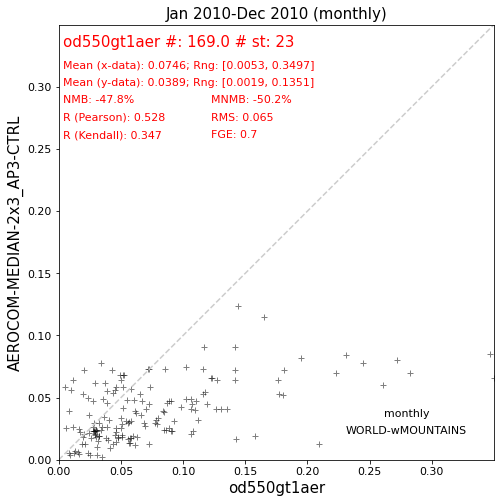

In [14]:
colocated_data.plot_scatter()

<GeoAxesSubplot:>

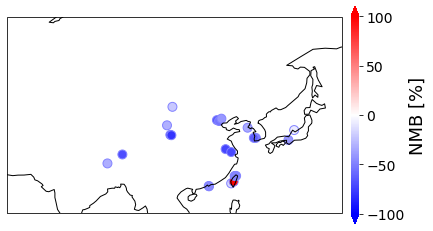

In [19]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.set_extent([60,150,15,60])
ax.coastlines()
pya.plot.mapping.plot_nmb_map_colocateddata(colocated_data, ax=ax)